In [21]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
print(train_terms.shape)
train_embeddings = np.load('/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_embeddings.npy')
print(train_embeddings.shape)
train_protein_ids = np.load('/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_ids.npy')
print(train_protein_ids.shape)

(5363863, 3)
(142246, 1280)
(142246,)


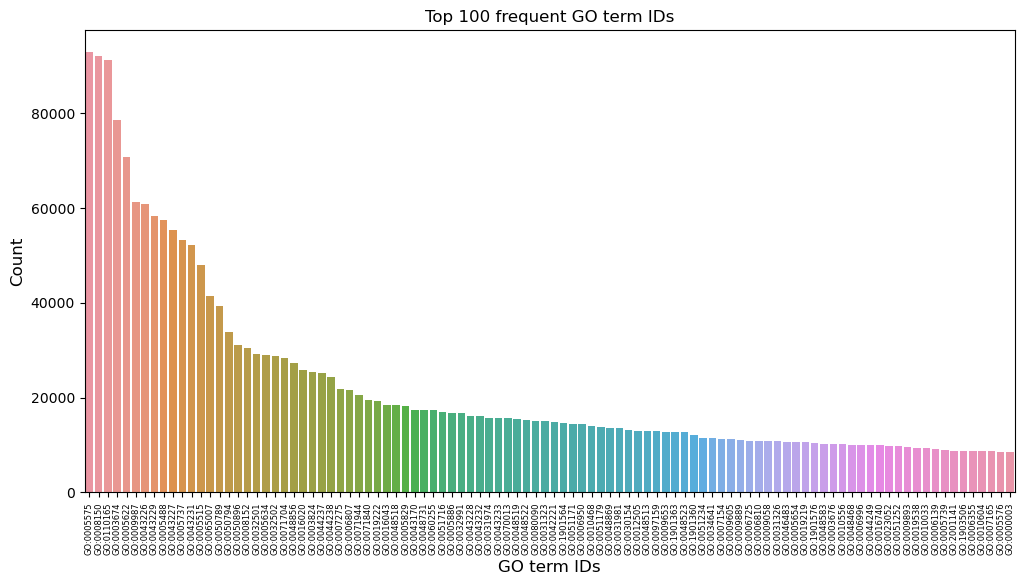

In [23]:
# Select first 100 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [24]:
# Load in IA terms 
file_path = '/kaggle/input/cafa-5-protein-function-prediction/IA.txt'
IA_df = pd.read_csv(file_path, sep='\t', header=None, names=['term', 'weight'])
print(IA_df)

             term    weight
0      GO:0000001  0.000000
1      GO:0000002  3.103836
2      GO:0000003  3.439404
3      GO:0000011  0.056584
4      GO:0000012  6.400377
...           ...       ...
43243  GO:2001083  7.159871
43244  GO:2001084  7.592457
43245  GO:2001085  7.159871
43246  GO:2001147  5.554589
43247  GO:2001227  0.000000

[43248 rows x 2 columns]


In [25]:
# Weight GO term frequencies according to their information accretion scores
frequency_df = train_terms['term'].value_counts().reset_index()
frequency_df.columns = ['term', 'frequency']
print(frequency_df)
merged_df = pd.merge(frequency_df, IA_df, on='term')
merged_df['weighted_frequency'] = merged_df['frequency'] * (1 + merged_df['weight']/2)
sorted_df = merged_df.sort_values(by='weighted_frequency', ascending=False)
print(sorted_df)

             term  frequency
0      GO:0005575      92912
1      GO:0008150      92210
2      GO:0110165      91286
3      GO:0003674      78637
4      GO:0005622      70785
...           ...        ...
31461  GO:0031772          1
31462  GO:0042324          1
31463  GO:0031771          1
31464  GO:0051041          1
31465  GO:0102628          1

[31466 rows x 2 columns]
             term  frequency    weight  weighted_frequency
0      GO:0005575      92912  0.000000        92912.000000
2      GO:0110165      91286  0.025471        92448.574820
1      GO:0008150      92210  0.000000        92210.000000
4      GO:0005622      70785  0.366945        83772.114011
5      GO:0009987      61293  0.589193        79349.703437
...           ...        ...       ...                 ...
30198  GO:1905068          1  0.000000            1.000000
30196  GO:0070409          1  0.000000            1.000000
27310  GO:0019475          1  0.000000            1.000000
29344  GO:1904303          1  0.0000

In [27]:
# Take 1500 most frequent GO terms to train on, or use weighted frequencies 
n_labels = 1500

# No IA weighting
# labels = train_terms['term'].value_counts().index[:n_labels].tolist()
# trimmed_train_terms = train_terms.loc[train_terms['term'].isin(labels)]

# Weights adjustment 
labels = sorted_df['term'][:n_labels].tolist()
trimmed_train_terms = train_terms.loc[train_terms['term'].isin(labels)]

In [28]:
# Create label matrix containing 1s and 0s indicating whether a protein has a certain function
df_pivot = trimmed_train_terms.pivot(index = 'EntryID', columns = 'term', values='EntryID')
df_pivot = df_pivot.notnull().astype(int)
df_labels = df_pivot.loc[train_protein_ids, labels] # orders columns to match embeddin order
labels_array = df_labels.values

In [29]:
print(labels_array.shape)

(142246, 500)


In [30]:
# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy
from sklearn.model_selection import train_test_split

In [31]:
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, input_shape, n_labels):
        super(MultiLayerPerceptron, self).__init__()
        
        self.linear1 = nn.Linear(input_shape, 864)
        self.activation1 = nn.ReLU() 
        self.linear2 = nn.Linear(864, 712)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(712, n_labels)
#         self.activation3 = nn.sigmoid() # no sigmoid?
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
#         x = self.activation3(x)
        return x

In [32]:
class CNN1D(nn.Module):

    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 3, kernel_size = 5, dilation = 1, padding = 2, stride = 1)
        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv1d(in_channels = 3, out_channels = 8, kernel_size = 5, dilation = 1, padding = 2, stride = 1)
        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(in_features = int(8 * input_dim / 4), out_features = 864)
        self.fc2 = nn.Linear(in_features = 864, out_features = num_classes)


    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.tanh(self.conv1(x)))
        x = self.pool2(nn.functional.tanh(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [33]:
def train_model(X, Y, n_labels, model):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    loss_function = nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(n_labels)
    
    # Training loop
    num_epochs = 5
    batch_size = 128
    train_losses = []
    test_losses = []
    train_f1_scores = []
    test_f1_scores = []
    
    train_f1_metric = MultilabelF1Score(n_labels)
    
    for epoch in range(num_epochs):
        model.train()
        train_f1_metric.reset()
        
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            batch_X = X_train_tensor[i:i+batch_size]
            batch_Y = Y_train_tensor[i:i+batch_size]
            preds = model(batch_X)
            loss = loss_function(preds, batch_Y)
            loss.backward()
            optimizer.step()
            train_f1_metric.update(preds, batch_Y)
    
        train_f1 = train_f1_metric.compute()
        train_f1_scores.append(train_f1)
        train_losses.append(loss.item())

        # Validation loop
        model.eval()
        with torch.no_grad():
            test_preds = model(X_test_tensor)
            test_loss = loss_function(test_preds, Y_test_tensor)
            test_f1 = f1_score(test_preds, Y_test_tensor)
            test_losses.append(test_loss.item())
            test_f1_scores.append(test_f1)

        scheduler.step(test_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss:.4f} - Train F1: {train_f1:.4f} - Test Loss: {test_loss:.4f} - Test F1: {test_f1:.4f}")
        
    return model

In [34]:
# Choose model
input_shape = train_embeddings.shape[1]
# chosen_model = CNN1D(input_shape, n_labels)
chosen_model = MultiLayerPerceptron(input_shape, n_labels)

In [35]:
model = train_model(train_embeddings, labels_array, n_labels, chosen_model)

Epoch [1/5] - Train Loss: 152.9808 - Train F1: 0.0587 - Test Loss: 142.1403 - Test F1: 0.0540
Epoch [2/5] - Train Loss: 152.9207 - Train F1: 0.0563 - Test Loss: 142.1096 - Test F1: 0.0542
Epoch [3/5] - Train Loss: 152.9009 - Train F1: 0.0562 - Test Loss: 142.0945 - Test F1: 0.0544
Epoch [4/5] - Train Loss: 152.8980 - Train F1: 0.0562 - Test Loss: 142.0818 - Test F1: 0.0546
Epoch [5/5] - Train Loss: 152.8856 - Train F1: 0.0563 - Test Loss: 142.0799 - Test F1: 0.0547


In [36]:
def predict(model):
    test_embeddings = np.load('/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_embeddings.npy')
    test_tensor = torch.tensor(test_embeddings, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        predictions = nn.functional.sigmoid(model(test_tensor))
    predictions_np = predictions.numpy()
    
    df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
    test_protein_ids = np.load('/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_ids.npy')
    l = []
    for k in list(test_protein_ids):
        l += [ k] * predictions.shape[1]   

    df_submission['Protein Id'] = l
    df_submission['GO Term Id'] = labels * predictions.shape[0]
    df_submission['Prediction'] = predictions.ravel()
    return df_submission

In [37]:
df_submission = predict(model)
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")

In [38]:
df_submission

,Protein Id,GO Term Id,Prediction
0,Q9ZSA8,GO:0005575,0.929607
1,Q9ZSA8,GO:0110165,0.929965
2,Q9ZSA8,GO:0008150,0.928004
3,Q9ZSA8,GO:0005622,0.918506
4,Q9ZSA8,GO:0009987,0.908732
...,...,...,...
70931995,P0AG74,GO:0032259,0.185970
70931996,P0AG74,GO:0009507,0.201051
70931997,P0AG74,GO:0022613,0.150132
70931998,P0AG74,GO:0070647,0.174474
